In [59]:
## check if mount folder exists -- if not create it
!mkdir -p /home/walter_littor_al/geotools_sites
## mount bucket
!gcsfuse coastal_geotools_demo /home/walter_littor_al/geotools_sites

{"timestamp":{"seconds":1758211736,"nanos":909870539},"severity":"INFO","message":"Start gcsfuse/3.1.0 (Go version go1.24.0) for app \"\" using mount point: /home/walter_littor_al/geotools_sites\n"}
{"timestamp":{"seconds":1758211736,"nanos":909904523},"severity":"INFO","message":"GCSFuse config","config":{"AppName":"","CacheDir":"","Debug":{"ExitOnInvariantViolation":false,"Fuse":false,"Gcs":false,"LogMutex":false},"DisableAutoconfig":false,"EnableAtomicRenameObject":true,"EnableGoogleLibAuth":false,"EnableHns":true,"EnableNewReader":false,"FileCache":{"CacheFileForRangeRead":false,"DownloadChunkSizeMb":200,"EnableCrc":false,"EnableODirect":false,"EnableParallelDownloads":false,"ExperimentalExcludeRegex":"","ExperimentalParallelDownloadsDefaultOn":true,"MaxParallelDownloads":16,"MaxSizeMb":-1,"ParallelDownloadsPerFile":16,"WriteBufferSize":4194304},"FileSystem":{"DirMode":"755","DisableParallelDirops":false,"ExperimentalEnableDentryCache":false,"ExperimentalEnableReaddirplus":false,"F

# setup

## installs

In [1]:
%%capture
import sys
import os
sys.path.append('/home/walter_littor_al/Littoral_S2download/src')
from littoral import ee_s2,littoral_sites
import numpy as np  
import cv2
from PIL import Image
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Configure matplotlib to suppress font warnings and use any available font
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Suppress all font-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', message='.*font.*')
warnings.filterwarnings('ignore', message='.*findfont.*')
warnings.filterwarnings('ignore', message='.*Glyph.*')
warnings.filterwarnings('ignore', message='.*Liberation.*')

# Clear matplotlib font cache and rebuild it
try:
    font_manager._rebuild()
    print("✅ Font cache rebuilt")
except:
    pass

# Get list of actually available fonts
available_fonts = [f.name for f in font_manager.fontManager.ttflist]
print(f"Available fonts: {available_fonts[:5]}...")  # Show first 5

# Set matplotlib to use only guaranteed available fonts
matplotlib.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],  # Only use DejaVu Sans (most reliable)
    'font.size': 10,
    'axes.unicode_minus': False,
    'figure.max_open_warning': 0
})

# Set logging to suppress font manager messages
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
logging.getLogger('matplotlib.pyplot').setLevel(logging.ERROR)

print("✅ Matplotlib fonts reset to DejaVu Sans only")

Available fonts: ['cmr10', 'DejaVu Sans', 'STIXNonUnicode', 'DejaVu Serif', 'cmtt10']...
✅ Matplotlib fonts reset to DejaVu Sans only


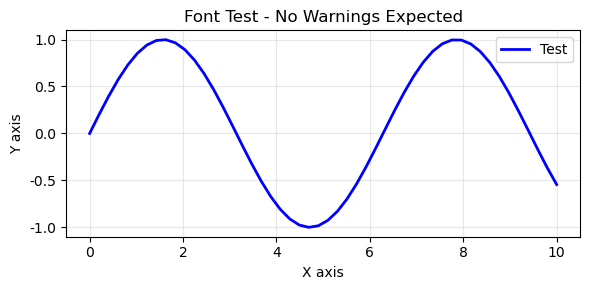

✅ Font test complete - any warnings above indicate configuration issues


In [3]:
# Test that font warnings are completely suppressed
import numpy as np

# Test plot - should have no font warnings
x = np.linspace(0, 10, 50)
y = np.sin(x)

plt.figure(figsize=(6, 3))
plt.plot(x, y, 'b-', linewidth=2, label='Test')
plt.title('Font Test - No Warnings Expected')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Font test complete - any warnings above indicate configuration issues")

In [4]:
# Create a function to reset matplotlib fonts completely
def reset_matplotlib_fonts():
    """Reset matplotlib to use only safe, available fonts"""
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib import font_manager
    import warnings
    import logging
    
    # Suppress all font warnings
    warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
    warnings.filterwarnings('ignore', message='.*font.*')
    warnings.filterwarnings('ignore', message='.*findfont.*')
    warnings.filterwarnings('ignore', message='.*Liberation.*')
    
    # Set logging levels
    logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
    logging.getLogger('matplotlib').setLevel(logging.ERROR)
    
    # Force rebuild font cache
    try:
        font_manager._rebuild()
    except:
        pass
    
    # Reset to safest font configuration
    matplotlib.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans'],
        'font.size': 10,
        'axes.unicode_minus': False,
        'figure.max_open_warning': 0,
        'figure.figsize': [6.4, 4.8]  # Default size
    })
    
    # Apply to current pyplot
    plt.rcParams.update(matplotlib.rcParams)
    
    print("✅ Matplotlib fonts completely reset - should eliminate all font warnings")

# Call the function immediately
reset_matplotlib_fonts()

✅ Matplotlib fonts completely reset - should eliminate all font warnings


## folder names

In [5]:
site_table_path = "/home/walter_littor_al/Littoral_S2download/littoral_sites.csv"
save_path = "/home/walter_littor_al/geotools_sites"

## folder names
tiff_folder = "TARGETS"
upsampled_folder = "UP"
normalized_folder = "NORMALIZED"
masked_folder = "MASK"
nir_folder = "RAWNIR"
rgb_folder = "RAWRGB"
cld_output_folder = "CLEAR"
clear_tiff_folder = "/TARGETS/cloudless"


## select site

In [6]:
littoral_sites.load_sites(path=site_table_path)

,id,site_name,aoi,start,end,max_cloudy_pixel_percentage,last_run,periodic
0,1,veyofushi_finolhu,"[\n [\n 73.13560806514303,\n 5.232300220203626\n ],\n [\n 73.14249432985883,\n 5.2376483570647\n ]\n ]",2024-01-01,2024-01-30,10,11/26/24,True
1,2,Vakharu,"[ [\n 73.49705943626319,\n 4.26141802708446\n ],\n [\n 73.50270164253178,\n 4.266148717007908\n ]\n ]",2024-01-01,2024-01-30,10,11/26/24,True
2,3,Fuvahmulah,"[\n [\n 73.40485831620961,\n -0.315466217603003\n ],\n [\n 73.4460947310398,\n -0.27336352803042985\n ]\n ]",2024-01-01,2024-01-30,10,11/26/24,True
3,4,Fenfushi,"[\n [\n 72.898,\n 5.379\n ],\n [\n 72.905,\n 5.3865\n ]\n ]",2024-01-01,2024-01-30,10,NaN,True
4,5,Bodufen,"[\n [\n 72.9201,\n 5.628\n ],\n [\n 72.9259,\n 5.6325\n ]\n ]",2024-01-01,2024-01-30,10,NaN,True
5,6,Goiymaru,"[\n [\n 72.884,\n 5.628\n ],\n [\n 72.891,\n 5.632\n ]\n ]",2024-01-01,2024-01-30,10,NaN,True
6,7,Lun’dhufushi,"[\n [\n 72.981,\n 5.64\n ],\n [\n 72.992,\n 5.647\n ]\n ]",2024-01-01,2024-01-30,10,NaN,True
7,8,Nauset,"[\n [\n -69.92896482901996,\n 41.77570649897041\n ],\n [\n -69.94188594216035,\n 41.78429419017735\n ]\n ]",2024-01-01,2024-01-30,10,NaN,False
8,5,mustique,"[[-61.206378936767585,12.848456541418054],[-61.154708862304695,12.901505084198375]]",2015-01-01,2025-01-01,5,NaN,True
9,6,anhenunfushi,"[[\n 72.95963024376084,\n 5.335849250143042\n ],[\n 72.97657581537973,\n 5.348010027325287\n ]]",2015-01-01,2025-01-01,75,NaN,True


In [7]:
names = littoral_sites.list_site_names(path=site_table_path)
site_name = names[4]
site_name

'Bodufen'

## tracking functions

In [8]:
# Pipeline tracking functions
def update_processing_status(site_path, filename, step_name, file_statuses=None, metrics=None):
    """
    Update the processing CSV with step completion status
    
    Args:
        site_path: Path to site directory
        filename: Processing CSV filename 
        step_name: Name of the pipeline step column
        file_statuses: Dict mapping image names to status ('success', 'failed', 'filtered')
        metrics: Dict of additional metrics to record
    """
    csv_path = f"{site_path}/{filename}"
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        
        if file_statuses:
            # Update individual file statuses
            for img_name, status in file_statuses.items():
                mask = df['name'] == img_name
                df.loc[mask, step_name] = status
        else:
            # Update all files with same status
            df[step_name] = 'success'
            
        # Add metrics as new columns if provided
        if metrics:
            for metric_name, metric_value in metrics.items():
                df[metric_name] = metric_value
                
        df.to_csv(csv_path, index=False)
        print(f"Updated {step_name} status in {filename}")
    else:
        print(f"Processing file not found: {csv_path}")

def get_processing_filename(site_path):
    """Get the most recent processing CSV filename"""
    import glob
    pattern = f"{site_path}/*_processing.csv"
    files = glob.glob(pattern)
    if files:
        return os.path.basename(max(files, key=os.path.getctime))
    return None

# Run Pipeline

## download imagery

In [6]:
%%capture
ee_s2.connect()
proj_params = littoral_sites.load_site_parameters_cg(site_name,save_path,site_table_path)

se2_col = ee_s2.get_filtered_image_collection(proj_params) # = ee_s2.get_image_collection(proj_params)

In [7]:
proj_params

{'aoi': [[72.9201, 5.628], [72.9259, 5.6325]],
 'start_date': '2024-01-01',
 'end_date': '2024-01-30',
 'max_cloudy_pixel_percentage': 10.0,
 'project_name': 'Bodufen',
 'path': '/home/walter_littor_al/geotools_sites/Bodufen',
 'periodic': 'True'}

In [8]:
se2_col.size().getInfo()

2

In [9]:
# #ee_s2.process_collection_images_totar(proj_params, se2_col,site_path=site_table_path)
results = ee_s2.process_collection_images_tofiles(proj_params, se2_col)

# Initialize processing dataframe with current date
from datetime import datetime
current_date = datetime.now().strftime("%Y%m%d")
processing_filename = f"{current_date}_processing.csv"

#save results to csv with date
df = pd.DataFrame(results)
# Add pipeline tracking columns
df['pipeline_run_date'] = current_date
df['step_1_download'] = 'success'
df['step_2_filter'] = 'pending'
df['step_3_coregister'] = 'pending'
df['step_4_cloud_impute'] = 'pending'
df['step_5_rgb_nir_creation'] = 'pending'
df['step_6_upsample'] = 'pending'
df['step_7_normalize'] = 'pending'
df['step_8_segment'] = 'pending'
df['step_9_boundary_extract'] = 'pending'
df['step_10_boundary_refine'] = 'pending'
df['step_11_geotransform'] = 'pending'
df['step_12_filter_shorelines'] = 'pending'
df['step_13_tide_model'] = 'pending'
df['step_14_tide_correct'] = 'pending'

df.to_csv(f"{save_path}/{site_name}/{processing_filename}",index=False)
print(f"Processing tracking saved to: {processing_filename}")
print(f"Downloaded {len(df)} images successfully")

landsat count = 61
Processing tracking saved to: 20250918_processing.csv
Downloaded 2 images successfully
Processing tracking saved to: 20250918_processing.csv
Downloaded 2 images successfully


## coregister

In [10]:
import sys
sys.path.append('/home/walter_littor_al/littoral_coreg/src')
from littoral_coregistration import LittoralCoregistration

/opt/conda/envs/littoral_pipeline/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [11]:
# Fix PROJ database context issue
import os
from pyproj import datadir
os.environ['PROJ_DATA'] = '/opt/conda/envs/littoral_pipeline/share/proj'
datadir.set_data_dir('/opt/conda/envs/littoral_pipeline/share/proj')

top_level = save_path + "/" + site_name
print("Top-level directory:", top_level)
# Run the coregistration workflow (no cleanup so we can inspect outputs)
coreg = LittoralCoregistration(top_level)
results = coreg.run(cleanup=True)
print("Result top-level keys:", list(results.keys())[:10])
print("Saved outputs in:", coreg.coregistered_dir)

# Update processing status for coregistration
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    update_processing_status(
        save_path + "/" + site_name, 
        processing_filename, 
        'step_3_coregister',
        metrics={'coregistered_files': len(results.get('coregistered_files', []))}
    )

Top-level directory: /home/walter_littor_al/geotools_sites/Bodufen
Reference file: ['LC08_146056_20230218.tif']
Target file count: 2
Found 2 files matching pattern '*.tif' in '/home/walter_littor_al/geotools_sites/Bodufen/TARGETS'.
Found 2 files matching pattern '*.tif' in '/home/walter_littor_al/geotools_sites/Bodufen/TARGETS'.


Coregistering Images:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(267005.0, 619895.0, 272875.0, 625585.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(267010.0, 619900.0, 272870.0, 625580.0)
Matching window position (X,Y): 269940.0/622740.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           0.45534977316856384/-0.40549731254577637
Calculated total shifts in fft pixel units (X/Y):         0.45534977316856384/-0.40549731254577637
Calculated total shifts in reference pixel units (X/Y):   0.45534977316856384/-0.40549731254577637
Calculated total shifts in target pixel units (X/Y):      0.45534977316856384/-0.40549731254577637
Calculated map shifts (X,Y):                              4.553497731685638/4.054973125457764
Calculated abs

Coregistering Images:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it]

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(267005.0, 619895.0, 272875.0, 625585.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(267010.0, 619900.0, 272870.0, 625580.0)
Matching window position (X,Y): 269940.0/622740.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           0.45892173051834106/-0.4290240406990051
Calculated total shifts in fft pixel units (X/Y):         0.45892173051834106/-0.4290240406990051
Calculated total shifts in reference pixel units (X/Y):   0.45892173051834106/-0.4290240406990051
Calculated total shifts in target pixel units (X/Y):      0.45892173051834106/-0.4290240406990051
Calculated map shifts (X,Y):                              4.589217305183411/4.290240406990051
Calculated absolut

Coregistering Images: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]



Saving coregistration results to /home/walter_littor_al/geotools_sites/Bodufen/coregistered/coreg_results.json
Filtered coregistration results saved to /home/walter_littor_al/geotools_sites/Bodufen/coregistered/filtered_files.csv
Number of failed coregistrations: 0 / 2 total
No failed coregistrations to move.
Filtered coregistration results saved to /home/walter_littor_al/geotools_sites/Bodufen/coregistered/filtered_files.csv
Number of failed coregistrations: 0 / 2 total
No failed coregistrations to move.
Successfully deleted the folder: /home/walter_littor_al/geotools_sites/Bodufen/modified_targets
Successfully deleted the folder: /home/walter_littor_al/geotools_sites/Bodufen/modified_targets
Successfully deleted the folder: /home/walter_littor_al/geotools_sites/Bodufen/modified_templates
Workflow complete.
Result top-level keys: ['20240121T052111_20240121T053340_T43NBG.tif', '20240126T052109_20240126T053414_T43NBG.tif', 'settings']
Saved outputs in: /home/walter_littor_al/geotools_si

## cloud impute

In [12]:
import sys
sys.path.append('/home/walter_littor_al/littoral_cloud_impute')

import vpint_cloud_impute
folder_path = save_path + "/" + site_name + "/" + tiff_folder
folder_path

'/home/walter_littor_al/geotools_sites/Bodufen/TARGETS'

In [13]:
# Run cloud imputation
cloud_results = vpint_cloud_impute.batch_remove_clouds_folder(folder_path)

# Update processing status for cloud imputation
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    update_processing_status(
        save_path + "/" + site_name, 
        processing_filename, 
        'step_4_cloud_impute'
    )

/home/walter_littor_al/VPint/VPint/utils/EO_utils.py:294: RuntimeWarning: load_tiff_windowed: No matching band descriptions found; falling back to sequential mapping by order.
  warnings.warn(
/opt/conda/envs/littoral_pipeline/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/envs/littoral_pipeline/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Selected features image: 20240121T052111_20240121T053340_T43NBG.tif (cloud=0.070)
Extracting 568x586 window at (0, 0)
Extracting 568x586 window at (0, 0)
[OK] Saved: /home/walter_littor_al/geotools_sites/Bodufen/TARGETS/cloudless/20240121T052111_20240121T053340_T43NBG_pred.tif
[OK] Saved: /home/walter_littor_al/geotools_sites/Bodufen/TARGETS/cloudless/20240121T052111_20240121T053340_T43NBG_pred.tif
Extracting 568x586 window at (0, 0)
Extracting 568x586 window at (0, 0)
[OK] Saved: /home/walter_littor_al/geotools_sites/Bodufen/TARGETS/cloudless/20240126T052109_20240126T053414_T43NBG_pred.tif
[OK] Saved: /home/walter_littor_al/geotools_sites/Bodufen/TARGETS/cloudless/20240126T052109_20240126T053414_T43NBG_pred.tif
[OK] Report saved: /home/walter_littor_al/geotools_sites/Bodufen/TARGETS/cloudless/cloudless_report.csv
[OK] Report saved: /home/walter_littor_al/geotools_sites/Bodufen/TARGETS/cloudless/cloudless_report.csv
Updated step_4_cloud_impute status in 20250918_processing.csv
Updated 

In [14]:
import pandas as pd
import os

# Find the CSV report in the cloudless folder
cloudless_folder = os.path.join(folder_path, "cloudless")
csv_files = [f for f in os.listdir(cloudless_folder) if f.endswith('.csv')]
report_path = os.path.join(cloudless_folder, csv_files[0])

# Load and display the CSV report
report_df = pd.read_csv(report_path)
report_df.head()

,image_name,image_date,cloud_coverage %,original_image_size,cloudless_image_size,image_CRS,image_Transform,band_names
0,20240121T052111_20240121T053340_T43NBG.tif,2024-01-21T05:21:11,7.01,568x586,568x586,EPSG:32643,"| 10.00, 0.00, 267010.00|\n| 0.00,-10.00, 625580.00|\n| 0.00, 0.00, 1.00|",NaN
1,20240126T052109_20240126T053414_T43NBG.tif,2024-01-26T05:21:09,39.22,568x586,568x586,EPSG:32643,"| 10.00, 0.00, 267010.00|\n| 0.00,-10.00, 625580.00|\n| 0.00, 0.00, 1.00|",NaN


## create cloudfree RGB and NIR images

In [15]:
import sys
sys.path.append('/home/walter_littor_al/Littoral_S2download/src')
from littoral import ee_s2

In [16]:
existing_nir_folder = folder_path = save_path + "/" + site_name + "/" + nir_folder
existing_rgb_folder = folder_path = save_path + "/" + site_name + "/" + rgb_folder
clear_output_folder = folder_path = save_path + "/" + site_name + "/" + cld_output_folder
clear_tiff_folder = folder_path = save_path + "/" + site_name + "/" + clear_tiff_folder

# Create the output folders if they don't exist
os.makedirs(clear_output_folder, exist_ok=True)

In [17]:
# Call the function with the existing variables
processed_files = ee_s2.process_cloud_imputed_images(
    existing_nir_folder=existing_nir_folder,
    existing_rgb_folder=existing_rgb_folder, 
    clear_tiff_folder=clear_tiff_folder,
    clear_output_folder=clear_output_folder
)

# Update processing status for RGB/NIR creation
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    update_processing_status(
        save_path + "/" + site_name, 
        processing_filename, 
        'step_5_rgb_nir_creation',
        metrics={'clear_images_created': len(processed_files)}
    )

Using band 8 for NIR: /home/walter_littor_al/geotools_sites/Bodufen//TARGETS/cloudless/20240121T052111_20240121T053340_T43NBG_pred.tif
NIR band stats for /home/walter_littor_al/geotools_sites/Bodufen//TARGETS/cloudless/20240121T052111_20240121T053340_T43NBG_pred.tif: min=824.4952650165103, max=7689.0, mean=1278.0983436881681
Saved: /home/walter_littor_al/geotools_sites/Bodufen/CLEAR/20240121T052111_20240121T053340_T43NBG_nir.png
Using band 8 for NIR: /home/walter_littor_al/geotools_sites/Bodufen//TARGETS/cloudless/20240126T052109_20240126T053414_T43NBG_pred.tif
NIR band stats for /home/walter_littor_al/geotools_sites/Bodufen//TARGETS/cloudless/20240126T052109_20240126T053414_T43NBG_pred.tif: min=899.5485468039652, max=7069.0, mean=1347.6892911568532
Saved: /home/walter_littor_al/geotools_sites/Bodufen/CLEAR/20240126T052109_20240126T053414_T43NBG_nir.png
Using band 8 for NIR: /home/walter_littor_al/geotools_sites/Bodufen//TARGETS/cloudless/20240126T052109_20240126T053414_T43NBG_pred.tif

## upsample

In [18]:
import sys
sys.path.append('/home/walter_littor_al/Real-ESRGAN')
from RealESRGAN.model import RealESRGAN
import RealESRGAN.model as re

/home/walter_littor_al/Real-ESRGAN/RealESRGAN/model.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast()


In [19]:
# # upsample from tar
# re.upsample_tar('geotools_sites/Fenfushi')
up_input = save_path + "/" + site_name + '/' + cld_output_folder
up_input

'/home/walter_littor_al/geotools_sites/Bodufen/CLEAR'

In [20]:
upsampled_images = re.upsample_folder(up_input)

# Update processing status for upsampling
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    update_processing_status(
        save_path + "/" + site_name, 
        processing_filename, 
        'step_6_upsample',
        metrics={'upsampled_images': len(upsampled_images)}
    )

upsampled_images

upsampling images from: /home/walter_littor_al/geotools_sites/Bodufen/CLEAR
Updated step_6_upsample status in 20250918_processing.csv
Updated step_6_upsample status in 20250918_processing.csv


['/home/walter_littor_al/geotools_sites/Bodufen/UP/20240121T052111_20240121T053340_T43NBG_nir_up.png',
 '/home/walter_littor_al/geotools_sites/Bodufen/UP/20240121T052111_20240121T053340_T43NBG_rgb_up.png',
 '/home/walter_littor_al/geotools_sites/Bodufen/UP/20240126T052109_20240126T053414_T43NBG_nir_up.png',
 '/home/walter_littor_al/geotools_sites/Bodufen/UP/20240126T052109_20240126T053414_T43NBG_rgb_up.png']

## remove defective images and normalize good images

In [21]:
import os
import glob
from PIL import Image
import numpy as np

up_folder = save_path + "/" + site_name + '/' + upsampled_folder
norm_out_folder = save_path + "/" + site_name + '/' + normalized_folder

os.makedirs(norm_out_folder, exist_ok=True)
nir_images = glob.glob(os.path.join(up_folder, '*_nir_up.png'))

# Track normalization results
normalized_files = []
skipped_files = []

for img_path in nir_images:
    img = Image.open(img_path)
    arr = np.array(img)
    # check if any pixel values are between 25 and 230
    if np.any((arr > 25) & (arr < 230)):
        #image has grey values - normalize
        arr = ((arr - arr.min()) / (np.ptp(arr) + 1e-6) * 255).astype(np.uint8)
        out_path = os.path.join(norm_out_folder, os.path.basename(img_path))
        Image.fromarray(arr).save(out_path)
        normalized_files.append(os.path.basename(img_path))
    else:
        #image has no grey values - skip
        print(f"Skipping normalization for {img_path} - no grey values")
        skipped_files.append(os.path.basename(img_path))
        continue

# Update processing status for normalization
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    update_processing_status(
        save_path + "/" + site_name, 
        processing_filename, 
        'step_7_normalize',
        metrics={
            'normalized_files': len(normalized_files),
            'skipped_normalization': len(skipped_files)
        }
    )

print(f"Normalized: {len(normalized_files)} images, Skipped: {len(skipped_files)} images")

Updated step_7_normalize status in 20250918_processing.csv
Normalized: 2 images, Skipped: 0 images


## segmentation

In [22]:
import sys
sys.path.append('/home/walter_littor_al/littoral_segment')
from seg_models.yolov8_seg import YOLOV8
YOLO_STD = YOLOV8(folder='/home/walter_littor_al/littoral_segment/seg_models/yolo8_params')

In [23]:
seg_imput_folder = save_path + "/" + site_name + '/'+ normalized_folder
seg_imput_folder

'/home/walter_littor_al/geotools_sites/Bodufen/NORMALIZED'

In [24]:
mask_paths = YOLO_STD.mask_from_folder(seg_imput_folder)

# Update processing status for segmentation
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    update_processing_status(
        save_path + "/" + site_name, 
        processing_filename, 
        'step_8_segment',
        metrics={'segmentation_masks': len(mask_paths)}
    )

mask_paths


0: 512x640 1 island, 65.5ms
Speed: 1.9ms preprocess, 65.5ms inference, 43.6ms postprocess per image at shape (1, 3, 512, 640)
0: 512x640 1 island, 65.5ms
Speed: 1.9ms preprocess, 65.5ms inference, 43.6ms postprocess per image at shape (1, 3, 512, 640)


0: 512x640 1 island, 83.8ms
Speed: 1.7ms preprocess, 83.8ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)
0: 512x640 1 island, 83.8ms
Speed: 1.7ms preprocess, 83.8ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)
Updated step_8_segment status in 20250918_processing.csv
Updated step_8_segment status in 20250918_processing.csv


['/home/walter_littor_al/geotools_sites/Bodufen/MASK/20240121T052111_20240121T053340_T43NBG_nir_mask.png',
 '/home/walter_littor_al/geotools_sites/Bodufen/MASK/20240126T052109_20240126T053414_T43NBG_nir_mask.png']

## batch process shorelines

In [9]:
sys.path.append('/home/walter_littor_al')
from littoral_refine import extract_boundary 
from littoral_refine import refine_boundary
# from littoral_refine import boundary_filter # filtering integrated into refinement

In [10]:
mask_folder = save_path + "/" + site_name + '/MASK'
shoreline_paths = extract_boundary.get_shorelines_from_folder(mask_folder)

# Update processing status for boundary extraction
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    update_processing_status(
        save_path + "/" + site_name, 
        processing_filename, 
        'step_9_boundary_extract',
        metrics={'extracted_boundaries': len(shoreline_paths)}
    )

Updated step_9_boundary_extract status in 20250918_processing.csv


In [11]:
refine_boundary.refine_shorelines(save_path + "/" + site_name)

# Update processing status for boundary refinement
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    update_processing_status(
        save_path + "/" + site_name, 
        processing_filename, 
        'step_10_boundary_refine'
    )

Found latest processing file: /home/walter_littor_al/geotools_sites/Bodufen/20250918_processing.csv
Skipping filtering, only 2 shorelines found.
Refining 2 shorelines...
20240121T052111_20240121T053340_T43NBG
Saving refined shoreline to: /home/walter_littor_al/geotools_sites/Bodufen/SHORELINE/20240121T052111_20240121T053340_T43NBG_nir_rl.csv
Saving refined shoreline to: /home/walter_littor_al/geotools_sites/Bodufen/SHORELINE/20240121T052111_20240121T053340_T43NBG_nir_rl.csv
Self intersection detected, trying kmeans thresholding...
Self intersection detected, trying kmeans thresholding...
Saving refined shoreline to: /home/walter_littor_al/geotools_sites/Bodufen/SHORELINE/20240121T052111_20240121T053340_T43NBG_nir_rl.csv
Saving refined shoreline to: /home/walter_littor_al/geotools_sites/Bodufen/SHORELINE/20240121T052111_20240121T053340_T43NBG_nir_rl.csv
unavoidable self-intersection detected, removing intersections...
20240126T052109_20240126T053414_T43NBG
unavoidable self-intersection 

# Prepare Shorelines for Analysis

## geotransform shorelines

In [12]:
sys.path.append('/home/walter_littor_al/Littoral_S2download/src')
from littoral import geo_transform

/opt/conda/envs/littoral_pipeline/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [13]:
cloudless_report_path = save_path + "/" + site_name + "/" + tiff_folder + "/cloudless/cloudless_report.csv"
coreg_path = save_path + "/" + site_name + "/coregistered/filtered_files.csv"
shoreline_path = save_path + "/" + site_name + "/SHORELINE"

In [14]:
geo_transform_results = geo_transform.batch_geotransform(shoreline_path,cloudless_report_path,coreg_path)

# Update processing status for geotransformation
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    update_processing_status(
        save_path + "/" + site_name, 
        processing_filename, 
        'step_11_geotransform'
    )

Updated step_11_geotransform status in 20250918_processing.csv


## filter and preview geotransformed shorelines

In [15]:
shoreline_path = save_path + "/" + site_name + "/SHORELINE"

geo_files = [f for f in os.listdir(shoreline_path) if f.endswith('o.csv')]
len(geo_files)

2

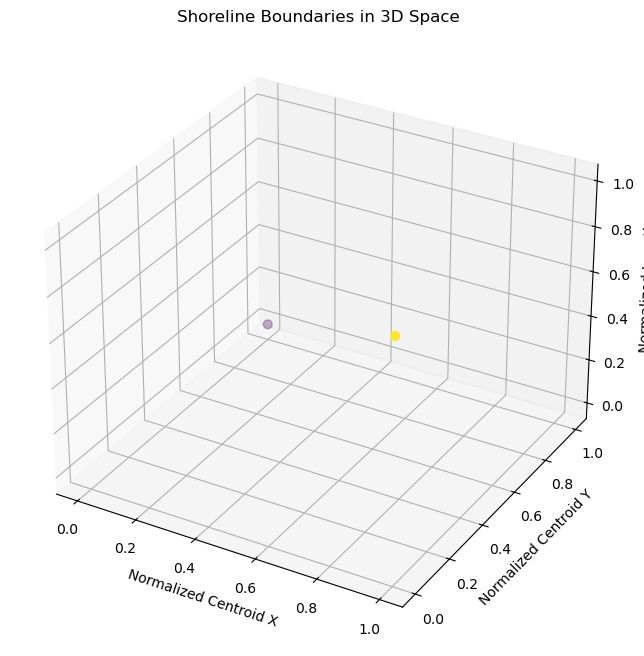

In [16]:
import pandas as pd
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Ensure font configuration is applied before any plotting
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'axes.unicode_minus': False
})

centroids = []
lengths = []

for csv_file in geo_files:
    csv_path = os.path.join(shoreline_path, csv_file)
    df = pd.read_csv(csv_path)
    x = df.iloc[:, 0].values
    y = df.iloc[:, 1].values

    # Calculate centroid
    centroid_x = np.mean(x)
    centroid_y = np.mean(y)
    centroids.append((centroid_x, centroid_y))

    # Calculate polyline length
    dx = np.diff(x)
    dy = np.diff(y)
    segment_lengths = np.sqrt(dx**2 + dy**2)
    total_length = np.sum(segment_lengths)
    lengths.append(total_length)

centroids = np.array(centroids)
lengths = np.array(lengths)

# Normalize centroid coordinates and lengths to [0, 1]
centroid_x_norm = (centroids[:, 0] - centroids[:, 0].min()) / (np.ptp(centroids[:, 0]) + 1e-6)
centroid_y_norm = (centroids[:, 1] - centroids[:, 1].min()) / (np.ptp(centroids[:, 1]) + 1e-6)
lengths_norm = (lengths - lengths.min()) / (np.ptp(lengths) + 1e-6)

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(centroid_x_norm, centroid_y_norm, lengths_norm, c=lengths_norm, cmap='viridis', s=40)
ax.set_xlabel('Normalized Centroid X')
ax.set_ylabel('Normalized Centroid Y')
ax.set_zlabel('Normalized Length')
ax.set_title('Shoreline Boundaries in 3D Space')
plt.show()

In [17]:
from sklearn.cluster import DBSCAN
import numpy as np

def filter_main_cluster(x, y, lengths_norm, eps=0.05, min_samples=10):
    """
    Identifies the main cluster in 3D space and removes outliers.

    Args:
        x (np.ndarray): X coordinates (normalized or raw).
        y (np.ndarray): Y coordinates (normalized or raw).
        lengths_norm (np.ndarray): Normalized lengths.
        eps (float): DBSCAN epsilon (distance threshold).
        min_samples (int): Minimum samples for a cluster.

    Returns:
        mask (np.ndarray): Boolean mask for points in the main cluster.
    """
    points = np.stack([x, y, lengths_norm], axis=1)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_
    # Find the largest cluster (excluding noise label -1)
    unique, counts = np.unique(labels[labels != -1], return_counts=True)
    if len(counts) == 0:
        # No clusters found, return all as outliers
        return np.zeros_like(labels, dtype=bool)
    main_cluster = unique[np.argmax(counts)]
    mask = labels == main_cluster
    return mask



In [18]:
mask = filter_main_cluster(centroid_x_norm, centroid_y_norm, lengths_norm)

#apply the mask to the geo_files list
if len(geo_files) < 50:
    filtered_geo_files = geo_files
else:
    filtered_geo_files = [geo_files[i] for i in range(len(geo_files)) if mask[i]]

# Update processing status for shoreline filtering
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    update_processing_status(
        save_path + "/" + site_name, 
        processing_filename, 
        'step_12_filter_shorelines',
        metrics={
            'total_shorelines': len(geo_files),
            'filtered_shorelines': len(filtered_geo_files),
            'filtering_applied': len(geo_files) >= 50
        }
    )

len(filtered_geo_files)

Updated step_12_filter_shorelines status in 20250918_processing.csv


2

In [19]:
import numpy as np
import pandas as pd
import os
from geomdl import BSpline, utilities

def get_datetime_from_filename(filename):
    # Assumes format: YYYYMMDDTHHMMSS...
    return pd.to_datetime(filename[:15], format='%Y%m%dT%H%M%S')

def get_spline_and_normals(x, y, num_points=200):
    points = list(zip(x, y))
    if points[0] != points[-1]:
        points.append(points[0])
    curve = BSpline.Curve()
    curve.degree = min(3, len(points) - 1)
    curve.ctrlpts = points
    curve.knotvector = utilities.generate_knot_vector(curve.degree, len(curve.ctrlpts))
    curve.delta = 1.0 / (num_points - 1)
    spline_points = np.array(curve.evalpts)
    normals = []
    for j in range(len(spline_points)):
        if j == 0:
            tangent = spline_points[j+1] - spline_points[j]
        elif j == len(spline_points) - 1:
            tangent = spline_points[j] - spline_points[j-1]
        else:
            tangent = spline_points[j+1] - spline_points[j-1]
        normal = np.array([-tangent[1], tangent[0]])
        norm_len = np.linalg.norm(normal)
        normals.append(normal / norm_len if norm_len > 0 else np.zeros_like(normal))
    return spline_points, np.array(normals)

def find_closest_point_and_distance(pt, other_spline):
    """
    Find the closest point on other_spline to pt and return distance and direction vector.
    
    Returns:
        distance (float): Distance to closest point
        direction (np.array): Direction vector from pt to closest point
    """
    distances = np.linalg.norm(other_spline - pt, axis=1)
    closest_idx = np.argmin(distances)
    closest_point = other_spline[closest_idx]
    distance = distances[closest_idx]
    direction = closest_point - pt
    # Normalize direction vector
    if distance > 0:
        direction = direction / distance
    else:
        direction = np.array([0, 0])
    return distance, direction

# Sort shorelines by datetime
shoreline_info = []
for fname in filtered_geo_files:
    dt = get_datetime_from_filename(fname)
    shoreline_info.append((dt, fname))
shoreline_info.sort()
sorted_files = [f for _, f in shoreline_info]

# Precompute splines and normals for all shorelines
shoreline_splines = []
shoreline_normals = []
for fname in sorted_files:
    df = pd.read_csv(os.path.join(shoreline_path, fname))
    x = df['xm'].values if 'xm' in df.columns else df.iloc[:, 0].values
    y = df['ym'].values if 'ym' in df.columns else df.iloc[:, 1].values
    spline, normals = get_spline_and_normals(x, y)
    shoreline_splines.append(spline)
    shoreline_normals.append(normals)

# First loop: Calculate overall average distance across all shorelines
all_distances = []
for i in range(1, len(shoreline_splines) - 1):
    curr_spline = shoreline_splines[i]
    prev_spline = shoreline_splines[i-1]
    next_spline = shoreline_splines[i+1]
    
    for pt in curr_spline:
        dist_prev, _ = find_closest_point_and_distance(pt, prev_spline)
        dist_next, _ = find_closest_point_and_distance(pt, next_spline)
        all_distances.extend([dist_prev, dist_next])

# Calculate global mean distance
global_mean_dist = np.mean(all_distances)
print(f"Global mean distance: {global_mean_dist:.3f}")
print(f"Total shorelines available for filtering: {len(shoreline_splines)}")

# Only apply defective shoreline filtering if we have more than 50 shorelines
if len(shoreline_splines) > 50:
    print("Applying defective shoreline filtering (>50 shorelines available)")
    # Filtering step using distance and direction criteria
    defective_indices = set()
    for i in range(1, len(shoreline_splines) - 1):
        curr_spline = shoreline_splines[i]
        prev_spline = shoreline_splines[i-1]
        next_spline = shoreline_splines[i+1]
        
        defective_points = 0
        total_points = len(curr_spline)
        
        for pt in curr_spline:
            dist_prev, dir_prev = find_closest_point_and_distance(pt, prev_spline)
            dist_next, dir_next = find_closest_point_and_distance(pt, next_spline)
            
            # Check if distances are 5 times the average
            if dist_prev > 5 * global_mean_dist or dist_next > 5 * global_mean_dist:
                # Check if direction vectors are within 90 degrees (dot product > 0)
                # If dot product > 0, angle is < 90 degrees
                dot_product = np.dot(dir_prev, dir_next)
                if dot_product > 0:  # Directions are closer than 90 degrees
                    defective_points += 1
        
        # If more than 10% of points are defective, mark the shoreline as defective
        if defective_points > 0.1 * total_points:
            defective_indices.add(i)
            print(f"Shoreline {i} marked as defective: {defective_points}/{total_points} defective points")
    
    # Filter out defective shorelines
    filtered2_sorted_files = [sorted_files[i] for i in range(len(sorted_files)) if i not in defective_indices]
    # get the defective filenames
    defective_files = [sorted_files[i] for i in defective_indices]
    
    print(f"Filtered out {len(defective_indices)} defective shorelines.")
    print(f"Remaining shorelines: {len(filtered2_sorted_files)}")
else:
    print("Skipping defective shoreline filtering (≤50 shorelines available)")
    print("Using all shorelines without defective filtering")
    # Use all shorelines without filtering
    filtered2_sorted_files = sorted_files.copy()
    defective_files = []
    defective_indices = set()
    
    print(f"Total shorelines used: {len(filtered2_sorted_files)}")

Global mean distance: nan
Total shorelines available for filtering: 2
Skipping defective shoreline filtering (≤50 shorelines available)
Using all shorelines without defective filtering
Total shorelines used: 2


/opt/conda/envs/littoral_pipeline/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/littoral_pipeline/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


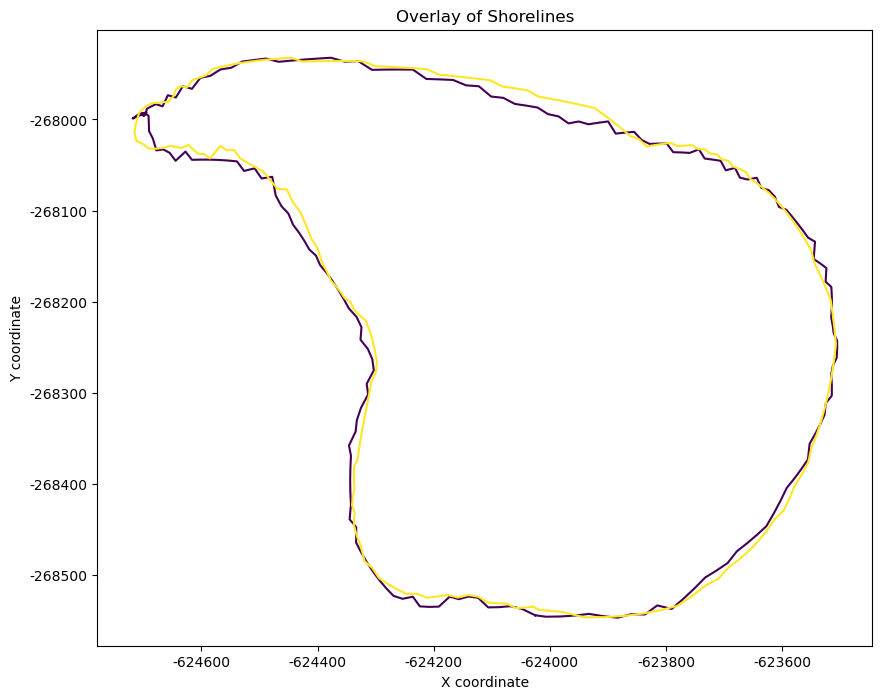

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for idx, csv_file in enumerate(filtered2_sorted_files):
    csv_path = os.path.join(shoreline_path, csv_file)
    df = pd.read_csv(csv_path)
    x = df.iloc[:, 1].tolist()
    y = df.iloc[:, 0].tolist()

    # Invert the y-axis
    y = [-val for val in y]
    x = [-val for val in x]

    # Close the curve by appending the first point to the end
    x.append(x[0])
    y.append(y[0])
    color = plt.cm.viridis(idx / max(len(filtered2_sorted_files) - 1, 1))
    plt.plot(x, y, linestyle='-', label=csv_file, color=color)

#show the defective files in red
for idx, csv_file in enumerate(defective_files):
    csv_path = os.path.join(shoreline_path, csv_file)
    df = pd.read_csv(csv_path)
    x = df.iloc[:, 1].tolist()
    y = df.iloc[:, 0].tolist()

    # Invert the y-axis
    y = [-val for val in y]
    x = [-val for val in x]

    # Close the curve by appending the first point to the end
    x.append(x[0])
    y.append(y[0])
    plt.plot(x, y, linestyle='--', label=csv_file, color='red')

plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Overlay of Shorelines")
plt.show()

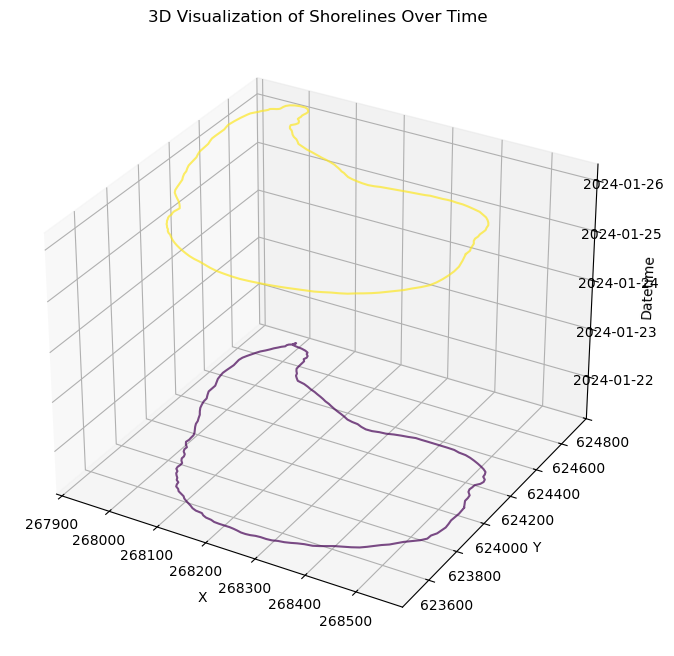

In [21]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Convert datetimes to numeric values (e.g., matplotlib date numbers)
import matplotlib.dates as mdates
datetime_nums = [mdates.date2num(dt) for dt, _ in shoreline_info]

for idx, (dt, fname) in enumerate(shoreline_info):

    # Get corresponding spline
    spline = shoreline_splines[idx]
    # Use x, y from spline
    x = spline[:, 0]
    y = spline[:, 1]
    # Use the same datetime for all points in this shoreline
    z = np.full_like(x, mdates.date2num(dt), dtype=float)
    # if defective, plot in red
    if fname in defective_files:
        ax.plot(x, y, z, label=fname if idx < 10 else None, alpha=0.7, color='red')
    else:
        color = plt.cm.viridis(idx / max(len(shoreline_info) - 1, 1))
        ax.plot(x, y, z, label=fname if idx < 10 else None, alpha=0.7, color=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Datetime')
ax.set_title('3D Visualization of Shorelines Over Time')
ax.zaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

## calculate tidal offsets for datetimes

In [22]:
## mount bucket
!mkdir -p /home/walter_littor_al/tide_model
!gcsfuse --implicit-dirs --dir-mode 777 --file-mode 777 aviso-fes2022 /home/walter_littor_al/tide_model

{"timestamp":{"seconds":1758245496,"nanos":644912759},"severity":"INFO","message":"Start gcsfuse/3.1.0 (Go version go1.24.0) for app \"\" using mount point: /home/walter_littor_al/tide_model\n"}
{"timestamp":{"seconds":1758245496,"nanos":644957608},"severity":"INFO","message":"GCSFuse config","config":{"AppName":"","CacheDir":"","Debug":{"ExitOnInvariantViolation":false,"Fuse":false,"Gcs":false,"LogMutex":false},"DisableAutoconfig":false,"EnableAtomicRenameObject":true,"EnableGoogleLibAuth":false,"EnableHns":true,"EnableNewReader":false,"FileCache":{"CacheFileForRangeRead":false,"DownloadChunkSizeMb":200,"EnableCrc":false,"EnableODirect":false,"EnableParallelDownloads":false,"ExperimentalExcludeRegex":"","ExperimentalParallelDownloadsDefaultOn":true,"MaxParallelDownloads":16,"MaxSizeMb":-1,"ParallelDownloadsPerFile":16,"WriteBufferSize":4194304},"FileSystem":{"DirMode":"777","DisableParallelDirops":false,"ExperimentalEnableDentryCache":false,"ExperimentalEnableReaddirplus":false,"FileM

In [23]:
import sys
sys.path.append('/home/walter_littor_al/Littoral_S2download/src')
from littoral import littoral_tide_correction

In [24]:
## get a list of datetimes for tide modeling

import pandas as pd

#find the most recent *_processing.csv file
datetime_csv_path = get_processing_filename(f"{save_path}/{site_name}")

df_proc = pd.read_csv(f"{save_path}/{site_name}/{datetime_csv_path}")

# Extract image names
image_names = df_proc['name'] if 'name' in df_proc.columns else df_proc.iloc[:, 0]

# get the characters before the first underscore for each name
sample_date_strs = image_names.str.split('_').str[0]
# parse into a datetime object
times = pd.to_datetime(sample_date_strs, format='%Y%m%dT%H%M%S', utc=True)
times


0   2024-01-21 05:21:11+00:00
1   2024-01-26 05:21:09+00:00
Name: name, dtype: datetime64[ns, UTC]

In [25]:
## get the center of the island to locate the tide model

import json
center_location = None
#get the aoi from the json file
with open(f"{save_path}/{site_name}/{site_name}.json") as f:
    settings = json.load(f)
    aoi = settings['aoi']
    center_location = [sum(x) / len(x) for x in zip(*aoi)]

center_location


[72.923, 5.63025]

In [ ]:
# Convert times to numpy datetime64 array for pyTMD compatibility
times_array = times.dt.tz_localize(None).to_numpy()  # Remove timezone and convert to numpy array

# Fix PROJ database context issue for tide modeling
import os
from pyproj import datadir
os.environ['PROJ_DATA'] = '/opt/conda/envs/littoral_pipeline/share/proj'
datadir.set_data_dir('/opt/conda/envs/littoral_pipeline/share/proj')

tide_df = littoral_tide_correction.model_tides(
    center_location[1], 
    center_location[0],
    times_array,  # Use the converted array
    model="fes2022b",
    directory="/home/walter_littor_al/tide_model",
    epsg=4326,
    method="bilinear",
    extrapolate=True,
    cutoff=10.0,
)

In [ ]:
tide_df = littoral_tide_correction.calculate_tide_corrections(tide_df,reference_elevation=0,beach_slope=0.08)

# Debug: Check what columns are actually in tide_df
print("Available columns in tide_df:", tide_df.columns.tolist())
print("tide_df shape:", tide_df.shape)

# Update processing status for tidal modeling
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    # Check if horizontal_correction_m column exists, if not use alternative
    if 'horizontal_correction_m' in tide_df.columns:
        avg_correction = float(tide_df['horizontal_correction_m'].mean())
    elif 'tide' in tide_df.columns:
        # Use tide values as a fallback
        avg_correction = float(tide_df['tide'].mean())
    else:
        avg_correction = 0.0
    
    update_processing_status(
        save_path + "/" + site_name, 
        processing_filename, 
        'step_13_tide_model',
        metrics={
            'tidal_predictions': len(tide_df),
            'tide_range_m': float(tide_df['tide'].max() - tide_df['tide'].min()) if 'tide' in tide_df.columns else 0.0,
            'avg_correction_m': avg_correction
        }
    )

tide_df.head()

Available columns in tide_df: ['dates', 'x', 'y', 'tide', 'cross_distance']
tide_df shape: (2, 5)
Updated step_13_tide_model status in 20250918_processing.csv
Updated step_13_tide_model status in 20250918_processing.csv


,dates,x,y,tide,cross_distance
0,2024-01-21 05:21:11+00:00,5.63025,72.923,0.000881,0.011011
1,2024-01-26 05:21:09+00:00,5.63025,72.923,-0.367291,-4.591142


In [ ]:
# save tide_df to csv
csv_path = f"{save_path}/{site_name}/tide_corrections.csv"
tide_df.to_csv(csv_path, index=False)
csv_path

'/home/walter_littor_al/geotools_sites/Bodufen/tide_corrections.csv'

In [ ]:
!fusermount -u /home/walter_littor_al/tide_model

## offsetting shorelines for tides

In [ ]:
import sys
sys.path.append('/home/walter_littor_al/Littoral_S2download/src')
from littoral import littoral_tide_correction

In [ ]:
tidal_corrections_csv = f"{save_path}/{site_name}/tide_corrections.csv"

if os.path.exists(tidal_corrections_csv):
    print(f"Using tidal corrections from: {tidal_corrections_csv}")
    
    # Apply tidal corrections to filtered shorelines
    corrected_shoreline_paths = littoral_tide_correction.apply_tidal_corrections_to_shorelines(
        filtered_shoreline_files=filtered_geo_files,
        shoreline_path=shoreline_path,
        tidal_corrections_path=tidal_corrections_csv,
        output_folder="TIDAL_CORRECTED"
    )
    print(f"Corrected shorelines saved to: {len(corrected_shoreline_paths)} files")
    
    # Update processing status for tidal corrections - FINAL STEP
    processing_filename = get_processing_filename(save_path + "/" + site_name)
    if processing_filename:
        update_processing_status(
            save_path + "/" + site_name, 
            processing_filename, 
            'step_14_tide_correct',
            metrics={
                'corrected_shorelines': len(corrected_shoreline_paths),
                'pipeline_complete': True
            }
        )
        print(f"✅ PIPELINE COMPLETE! Full tracking saved in {processing_filename}")
    
else:
    print(f"Tidal corrections file not found at: {tidal_corrections_csv}")
    print("Please run the tidal modeling section first to generate tide corrections.")

Using tidal corrections from: /home/walter_littor_al/geotools_sites/Bodufen/tide_corrections.csv
Loaded tidal corrections with 2 entries
Created output directory: /home/walter_littor_al/geotools_sites/Bodufen/TIDAL_CORRECTED
Processing 1/2: 20240121T052111_20240121T053340_T43NBG_nir_geo.csv
  Tidal correction: 0.011 m
  Saved corrected shoreline: 20240121T052111_20240121T053340_T43NBG_nir_geo_tidal_corrected.csv
Processing 2/2: 20240126T052109_20240126T053414_T43NBG_nir_geo.csv
  Tidal correction: 0.011 m
  Saved corrected shoreline: 20240121T052111_20240121T053340_T43NBG_nir_geo_tidal_corrected.csv
Processing 2/2: 20240126T052109_20240126T053414_T43NBG_nir_geo.csv
  Tidal correction: -4.591 m
  Saved corrected shoreline: 20240126T052109_20240126T053414_T43NBG_nir_geo_tidal_corrected.csv

Successfully processed 2 out of 2 shorelines
Corrected shorelines saved to: 2 files
  Tidal correction: -4.591 m
  Saved corrected shoreline: 20240126T052109_20240126T053414_T43NBG_nir_geo_tidal_corre

## visualize tidally corrected shorelines

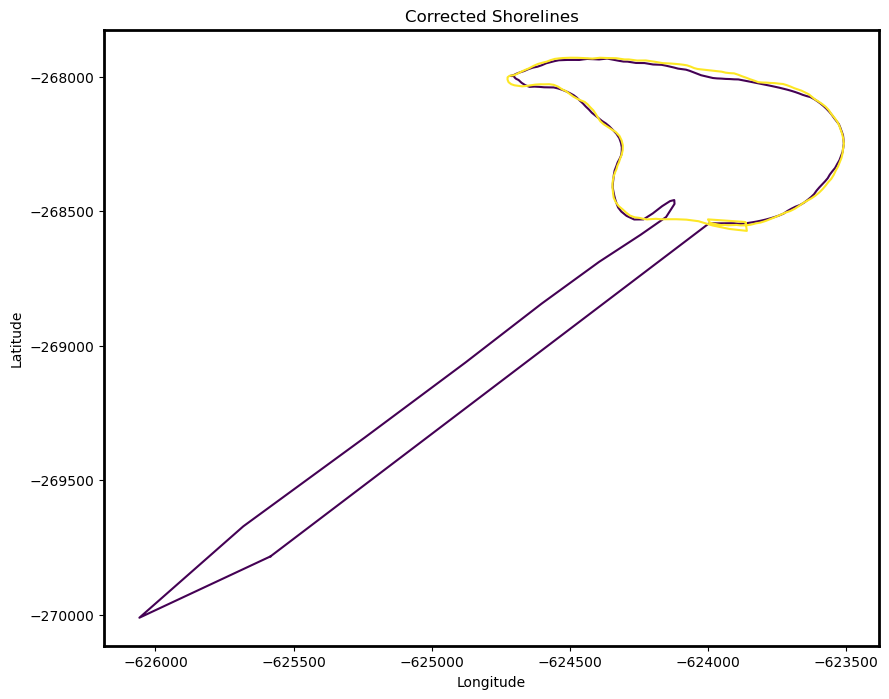

In [ ]:
#visualize corrected shorelines
import pandas as pd
import os
import matplotlib.pyplot as plt
corrected_shoreline_folder = shoreline_path.replace("SHORELINE","TIDAL_CORRECTED")
corrected_files = [f for f in os.listdir(corrected_shoreline_folder) if f.endswith('_tidal_corrected.csv')]

plt.figure(figsize=(10, 8))
for idx, csv_file in enumerate(corrected_files):
    csv_path = os.path.join(corrected_shoreline_folder, csv_file)
    df = pd.read_csv(csv_path)
    x = df.iloc[:, 1].tolist()
    y = df.iloc[:, 0].tolist()

    # Invert the y-axis
    y = [-val for val in y]
    x = [-val for val in x]

    # Close the curve by appending the first point to the end
    x.append(x[0])
    y.append(y[0])
    color = plt.cm.viridis(idx / max(len(corrected_files) - 1, 1))
    plt.plot(x, y, linestyle='-', label=csv_file, color=color)

plt.title("Corrected Shorelines")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

# Pipeline Summary

In [ ]:
# Display final pipeline summary
processing_filename = get_processing_filename(save_path + "/" + site_name)
if processing_filename:
    final_df = pd.read_csv(f"{save_path}/{site_name}/{processing_filename}")
    
    print("="*60)
    print(f"LITTORAL PIPELINE SUMMARY - {site_name}")
    print(f"Run Date: {final_df['pipeline_run_date'].iloc[0]}")
    print("="*60)
    
    # Count step completions
    step_columns = [col for col in final_df.columns if col.startswith('step_')]
    step_status = {}
    
    for step_col in step_columns:
        success_count = (final_df[step_col] == 'success').sum()
        total_count = len(final_df)
        step_status[step_col] = f"{success_count}/{total_count}"
    
    # Display step summary
    step_names = {
        'step_1_download': '1. Download Imagery',
        'step_2_filter': '2. Initial Filter',
        'step_3_coregister': '3. Coregister',
        'step_4_cloud_impute': '4. Cloud Imputation',
        'step_5_rgb_nir_creation': '5. RGB/NIR Creation',
        'step_6_upsample': '6. Upsampling',
        'step_7_normalize': '7. Normalization',
        'step_8_segment': '8. Segmentation',
        'step_9_boundary_extract': '9. Boundary Extraction',
        'step_10_boundary_refine': '10. Boundary Refinement',
        'step_11_geotransform': '11. Geotransformation',
        'step_12_filter_shorelines': '12. Shoreline Filtering',
        'step_13_tide_model': '13. Tidal Modeling',
        'step_14_tide_correct': '14. Tidal Correction'
    }
    
    for step_col in step_columns:
        if step_col in step_status:
            status = step_status[step_col]
            name = step_names.get(step_col, step_col)
            print(f"{name}: {status}")
    
    # Display key metrics
    print("\n" + "="*60)
    print("KEY METRICS:")
    print("="*60)
    
    metrics_to_show = [
        'coregistered_files', 'clear_images_created', 'upsampled_images',
        'normalized_files', 'skipped_normalization', 'segmentation_masks',
        'extracted_boundaries', 'total_shorelines', 'filtered_shorelines',
        'corrected_shorelines', 'tidal_predictions', 'tide_range_m',
        'avg_correction_m'
    ]
    
    for metric in metrics_to_show:
        if metric in final_df.columns:
            value = final_df[metric].iloc[0] if not pd.isna(final_df[metric].iloc[0]) else 'N/A'
            print(f"{metric.replace('_', ' ').title()}: {value}")
    
    print("\n" + "="*60)
    if 'pipeline_complete' in final_df.columns and final_df['pipeline_complete'].iloc[0]:
        print("✅ PIPELINE STATUS: COMPLETE")
    else:
        print("⚠️  PIPELINE STATUS: IN PROGRESS")
    print("="*60)
    
    print(f"\nDetailed results saved to: {processing_filename}")
else:
    print("No processing file found!")

LITTORAL PIPELINE SUMMARY - Bodufen
Run Date: 20250918
1. Download Imagery: 2/2
2. Initial Filter: 0/2
3. Coregister: 2/2
4. Cloud Imputation: 2/2
5. RGB/NIR Creation: 2/2
6. Upsampling: 2/2
7. Normalization: 2/2
8. Segmentation: 2/2
9. Boundary Extraction: 2/2
10. Boundary Refinement: 2/2
11. Geotransformation: 2/2
12. Shoreline Filtering: 2/2
13. Tidal Modeling: 2/2
14. Tidal Correction: 2/2

KEY METRICS:
Coregistered Files: 0
Clear Images Created: 4
Upsampled Images: 4
Normalized Files: 2
Skipped Normalization: 0
Segmentation Masks: 2
Extracted Boundaries: 2
Total Shorelines: 2
Filtered Shorelines: 2
Corrected Shorelines: 2
Tidal Predictions: 2
Tide Range M: 0.3681722629619863
Avg Correction M: -0.1832052519484351

✅ PIPELINE STATUS: COMPLETE

Detailed results saved to: 20250918_processing.csv


# unmount bucket with gcfuse

In [57]:
!fusermount -u /home/walter_littor_al/geotools_sites